In [66]:
import warnings
warnings.filterwarnings('ignore')

import pathlib
import importlib
import re

import pandas as pd
import numpy as np
import feather
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy import stats
import dexplot as dxp
import scipy.stats as ss

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from category_encoders.target_encoder import TargetEncoder

pd.options.display.float_format = '{:,.4f}'.format


# Outline

In the previous workshop, we spent some time exploring our dataset. Now that we have a good sense for how our data looks like, we will use what we learned to build the pipeline that will apply transformations we need to impose on our dataset before we use it to train a model. This process is called the feature engineering or data preprocessing. 

This is a very important part of the machine learning lifecycle--perhaps more important than what model you will train--because the quality of your data will have a strong influence on the predicitive performance your model.


In [52]:
DATA_PATH = pathlib.Path('./data')
RESULTS_PATH = pathlib.Path('./results')
SAMPLE = True  # set to False to apply transformations to the entire dataset

In [53]:
df = pd.read_csv(DATA_PATH / 'accepted_2007_to_2018Q4.csv')

if SAMPLE:
    # Take a subsample of your dataset
    # Useful when developing your pipeline for faster 
    # turnaround time when you just want to test your code
    df = df.sample(frac=0.1)

In [54]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 
             'grade', 'home_ownership', 'initial_list_status', 
             'installment', 'int_rate', 'issue_d', 'loan_amnt', 
             'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
             'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 
             'title', 'total_acc', 'verification_status', 'loan_status']
keep_list.sort()
df = df[keep_list]

# Create Target Variable

In [55]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [56]:
df['target'] = 1
df['target'] = (df['target'].where(df['loan_status'] == 'Charged Off', 0))
df = df.drop('loan_status', axis=1)

In [57]:
# Reminding ourselves of the data imbalance ratio
df['target'].value_counts()/df['target'].count()

0   0.800
1   0.200
Name: target, dtype: float64

# Get Columns by Type

In [58]:
# Numerical columns
num_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)
num_cols.remove('target')

In [59]:
# Date-based columns
dates_cols = ['earliest_cr_line', 'issue_d']
for c in dates_cols:
    df[c] = pd.to_datetime(df[c], format='%b-%Y')

In [60]:
# Categorical columns
cat_cols = list(df.select_dtypes('object').columns)

# Split training from test set

In [ ]:
train_years = [2013, 2014, 2015]
test_years = [2016]
train_df = df[df['issue_d'].dt.year.isin(train_years)]
test_df = df[df['issue_d'].dt.year.isin(test_years)]

# Preprocessing

Let's start with some preprocessing now that we have some understanding of the data.

We need to start filling the missing values.

* For numerical columns, for simplicity, we are going to fill missing values with the median.
* For categorical columns, a simple approach would be to fill the missing values with the most common observation.

Keep in mind that these approaches are just to keep things simple. If one thinks that more time should be spent on preprocessing, they could go with fancier methods, such as using other ML models to come up with values for missing data.

Another approach is to create another variable the indicates that a record is missing. So if income has missing values, for example, we can impute it with the median. We can then generate a new variable called missing_income_indicator which takes the value of 1 if income is missing and 0 otherwise.

When filling in the missing values, it is important that we calculate this value using the training set only during the training phase, so as to prevent test set information from leaking. If you were to use the median to fill in the missing values, the dataset used to get the median should __only__ be from the training dataset. You will then apply this same median value to that same variable in the test set. Using the entire dataset (training + test) to estimate missing values can cause overfitting to the test set that may artificially boosting the performance.

## Filling Missing Values

In [76]:
# What share of each columns are missing records?
m = df.isnull().mean().sort_values(ascending=False)
m[m>0]

emp_length             0.0578
mort_acc               0.0359
title                  0.0125
revol_util             0.0007
pub_rec_bankruptcies   0.0006
dti                    0.0003
dtype: float64

A simple approach for numerical features: Fill with the median

For categorical features we can fill with the most frequent values

In [13]:
def preprocessing(df, num_cols, cat_cols):

    for col in num_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)

    for col in cat_cols:
        most_common = df[col].mode()[0]
        df[col] = df[col].fillna(most_common)
    
    return df

# Remark: the training and test medians might not be exactly the same, so the values filled would be different
# This also applies to the most common observation, which may be different in the test set

# Feature Engineering

Now we do some basic feature engineering. 
For this workshop, this will consistly mostly of:
* scaling the numerical features ([not required for some by models such as decision trees]( https://sebastianraschka.com/faq/docs/when-to-standardize.html))
* encoding categorical features
* regular expression with some specific features


# Scaling
Some models rely on the distance between our datapoints in the feature space. Since distances can be scaled, these models can produce different results if features are not properly scaled. For example, if one numerical feature is always of the order of thousands, and another is of the order of units, the larger feature will tend to dominate any distance calculation.

To be concrete, suppose you had data on employees of a company with information on salary and age. Salary can range from $30k to $100k whereas age ranges only from 21 to 70 years. Two people who only have a difference of $10k in salary but are 30 years apart would be considered as "similar". The reason for this is because the distance metrics will sum up the difference across all the feature. The the final score will then be largely determined by the feature with the highest order, which, in this case, is salary.

To solve this problem, we scale features to ensure that they are of the same order. There are various ways to do that. Here are a few:

#### Standard Scaler:
Scales using the mean and standard deviation

#### Robust Scaler:
Scales using the median and a certain quantile interval

#### Min-Max Scaler:
Scales by ensuring that the minimum and maximum values are -1 and 1, respectively

In most applications, the standard scaler is sufficient.

Note that it may be worthwhile to apply feature scaling even if you are using a model that does not require it (e.g. decision trees). This way, you will have a dataset that can be readily applied to any algorithm to compare their performance against each other.

# Encoding 
Before we move on, let's briefly discuss encoding.

Most ML models require numeric inputs, which makes categorical features not usable in their raw form.
Encoding is a process in which we map the categories into numbers based on some criterion.

Here are a few examples of encodings:

#### Label Encoding:
 * First Label ---> 0
 * Second Label ---> 1
 * Third Label ---> 2

#### Ordinal Encoding:
 * Bad ---> 0
 * Average ---> 1
 * Good ---> 2

#### One-Hot Encoding
* First Label ---> [1 0 0]
* Second Label ---> [0 1 0]
* Third Label ---> [0 0 1]

Remark: one-hot encoding technically speaking converts our feature to three new features

#### Target Encoding

A popular encoding technique you can use where the above approaches are infeasible (such as high cardinality categorical features). The idea is to encode the categorical values of a feature using a number representing information about the target. For binary labels, this value is the probability of label being 1 given that category (or just the mean of the target). The drawback of this technique is it may lead to overfitting.


Naive label encoding may not be always appropriate, since it introduces an order to our categories that may not have existed before.
However, one-hot encoding can be costly to implement due to its tendency to introduce a high number of features.

For this workshop, we will stick to label encoders for simplicity, and because we are going to train a tree model. Tree models tend to be less susceptible to artifacts introduced by label encoders.

In [14]:
LABEL_ENCODERS = {}
TARGET_ENCODERS = {}
SCALER = StandardScaler()

log_cols = ['annual_inc', 'dti', 'int_rate', 'open_acc', 'total_acc']

# every feature encoded need their label encoder
# the scaler, however, can act on multiple columns

In [31]:
df['purpose'].value_counts() / len(df)

debt_consolidation    0.580031
credit_card           0.219488
home_improvement      0.065044
other                 0.057886
major_purchase        0.021872
medical               0.011562
small_business        0.011459
car                   0.010841
moving                0.007047
vacation              0.006738
house                 0.005391
wedding               0.001705
renewable_energy      0.000694
educational           0.000242
Name: purpose, dtype: float64

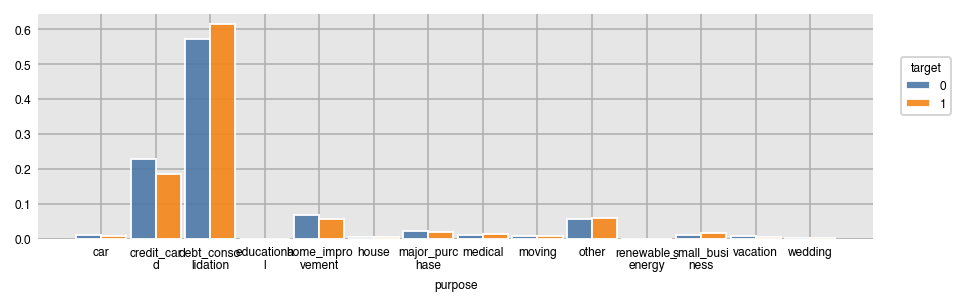

In [28]:
dxp.count('purpose', data=df, split='target', normalize='target')

In [71]:
def feature_engineering(df, num_cols, cat_cols, log_cols=None, is_train=True):
    ''' This function will be used to take the log of our features, scale our features, encodings, etc.'''

    # taking the log of features in log_cols
    # a problem is that at least one feature has neg values, so we are going to drop those rows
    df = df[df['dti'] > -1]
    if log_cols:
        for col in log_cols:
            df[col] = np.log1p(df[col])
    

    if is_train:
        df[num_cols] = SCALER.fit_transform(df[num_cols])
    else:
        df[num_cols] = SCALER.transform(df[num_cols])


    # some feature engineering specific to a variable
    df['emp_length'] = df['emp_length'].apply(lambda x: '0' if x is '< 1 year' else x)
    df['emp_length'] = df['emp_length'].str.replace('[^0-9]+', '')

    cat_cols = list(cat_cols)
    cat_cols.remove('emp_length')
    cat_cols.remove('purpose')

    # target encoding for high cardinality variable
    if is_train:
        TARGET_ENCODERS['purpose'] = TargetEncoder()
        df['purpose'] = TARGET_ENCODERS['purpose'].fit_transform(X=df['purpose'], y=df['target'])
    else:
        df['purpose'] = TARGET_ENCODERS['purpose'].transform(X=df['purpose'])

    for col in cat_cols:
        encoder = LabelEncoder()
        if is_train:
            df[col] = encoder.fit_transform(df[col])
            LABEL_ENCODERS[col] = encoder
        else:
            df[col] =LABEL_ENCODERS[col].transform(df[col])

    return df

In [72]:
train_df = preprocessing(train_df, num_cols, cat_cols)

In [73]:
train_df2 = feature_engineering(train_df, num_cols, cat_cols, log_cols=log_cols, is_train=True)

In [74]:
test_df = preprocessing(test_df, num_cols, cat_cols)

In [75]:
test_df2 = feature_engineering(test_df, num_cols, cat_cols, log_cols=log_cols, is_train=False)

In [76]:
train_df2.columns

Index(['addr_state', 'annual_inc', 'application_type', 'dti',
       'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low',
       'grade', 'home_ownership', 'initial_list_status', 'installment',
       'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
       'target'],
      dtype='object')

We will now drop some columns that we do not intend to use for various reasons:

- fico_range_high and fico_range_low are highly correlated, so let us keep one of them
- title and purpose are related; let us keep purpose, which we target encoded
- installment and loan_amnt are highly correlated, we keep loan_amnt,


In [77]:
cols = ['addr_state', 'annual_inc', 'application_type', 'dti',
       'emp_length', 'fico_range_high', 'grade', 'home_ownership', 'initial_list_status',
       'loan_amnt', 'int_rate', 'mort_acc',
       'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
       'revol_util', 'sub_grade', 'term', 'total_acc',
       'verification_status']

In [78]:
X_train = train_df2[cols]
y_train = train_df2['target']

In [79]:
X_test = test_df2[cols]
y_test = test_df2['target']

In [80]:
# Save datasets for modelling
feather.write_dataframe(X_train, DATA_PATH / 'X_train')
feather.write_dataframe(pd.DataFrame(y_train), DATA_PATH / 'y_train')
feather.write_dataframe(X_test, DATA_PATH / 'X_test')
feather.write_dataframe(pd.DataFrame(y_test), DATA_PATH / 'y_test')